Importing modules and the ct scan files

In [21]:
import numpy as np 
import pandas as pd 
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


INPUT_FOLDER = "/home/aiims/tumor/Sample" 
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(patients)

['1']


Loading the scans for the same 

In [26]:
first_patient_path = os.path.join(INPUT_FOLDER, patients[0])
print(f"Loading scans from: {first_patient_path}")
first_patient = load_scan(first_patient_path)

Loading scans from: /home/aiims/tumor/Sample/1


In [27]:
slices = [pydicom.read_file(first_patient_path + '/' + s) for s in os.listdir(first_patient_path)]
slices

[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 192
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.55.219945445115499117590389062871355310649
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
 (0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
 -------------------------------------------------
 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
 (0008, 0016) SOP Class UID                       UI: CT Image Storage
 (0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.219945445115499117590389062871355310649
 (0008, 0060) Modality                            CS: 'CT'
 (0008, 103e) Series Description                  LO: '

In [25]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


Function to get all the pixel's hounsfield value to view a certain scan's pixel values

In [28]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k) can also use others if we have larger database
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Resampling the images and generating it


In [29]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    slice_thickness = scan[0].SliceThickness
    pixel_spacing = scan[0].PixelSpacing
    
    # Ensure pixel_spacing is a numpy array
    if isinstance(pixel_spacing, list):
        pixel_spacing = np.array(pixel_spacing)
    elif isinstance(pixel_spacing, np.ndarray):
        # Ensure pixel_spacing is a 1D array
        if pixel_spacing.ndim != 1:
            raise ValueError("PixelSpacing should be a 1D numpy array or a list")

    # Convert slice_thickness to numpy array
    slice_thickness_array = np.array([slice_thickness])

    # Concatenate slice_thickness_array and pixel_spacing
    spacing = np.concatenate((slice_thickness_array, pixel_spacing))

    # Convert to float32 for consistency
    spacing = spacing.astype(np.float32)
    

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing 

Helps to plot the image in 3d for a better visualization

In [30]:
def plot_3d(image, threshold=-300):
    # Position the scan upright
    p = image.transpose(2,1,0)
    
    # Use marching_cubes to get vertices, faces, and normals
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection from vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    # Set the limits of the plot
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

helps to determine the largest label volume avialable

In [31]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


Helps in segmenting lungs from bones and other structures

In [32]:

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

The following is to get a visualization of what has happende till now to see how the functions perform

Just trying to visualize what has been done for the first patient this helps to show the shape before and after reampling has been done 

Plots the CT scan data of lungs

Loading scans from: /home/aiims/tumor/Sample/1


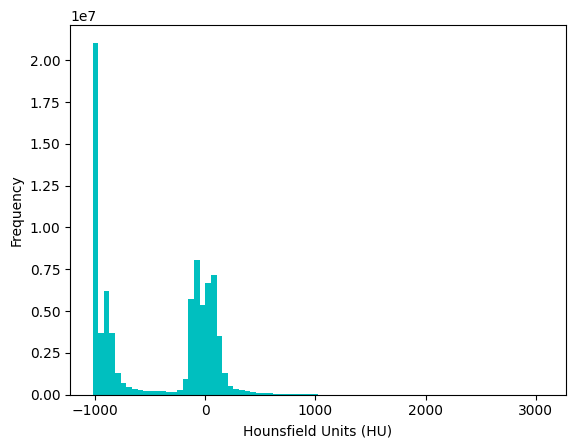

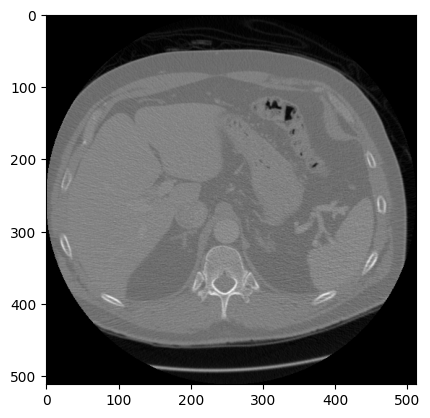

Shape before resampling	 (305, 512, 512)
Shape after resampling	 (381, 375, 375)


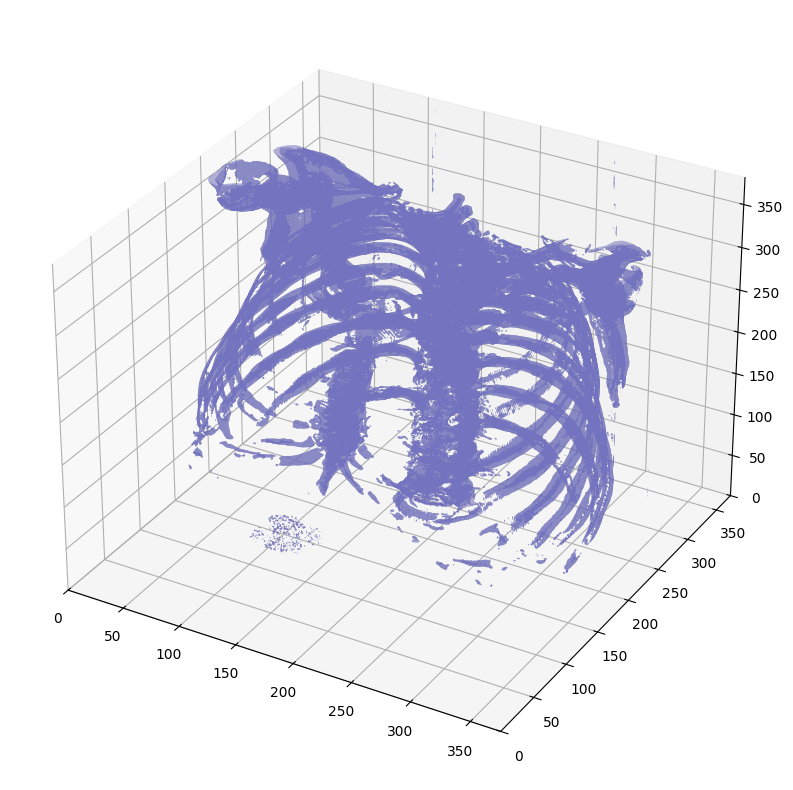

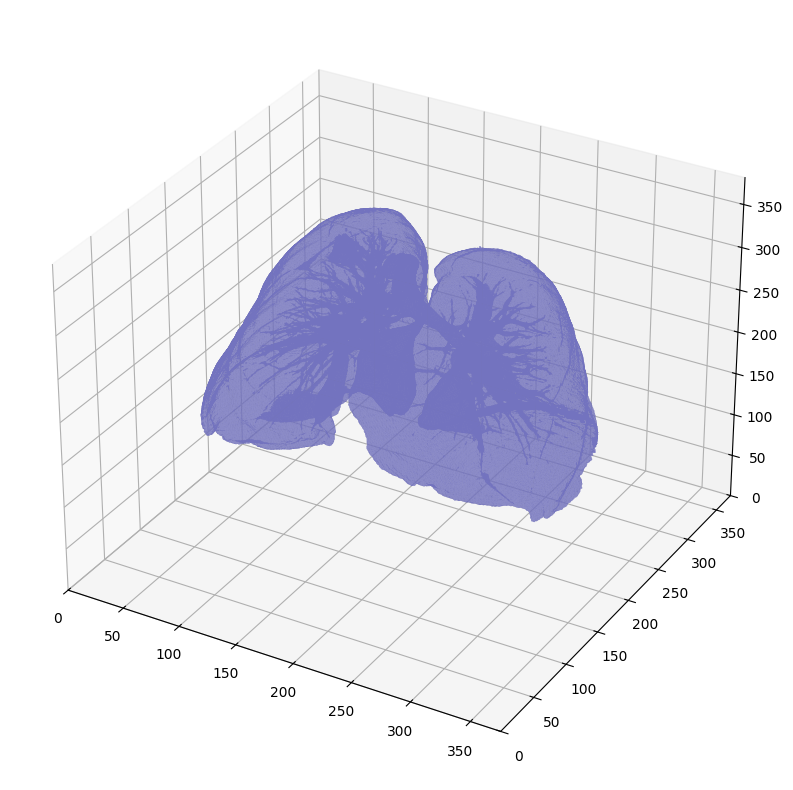

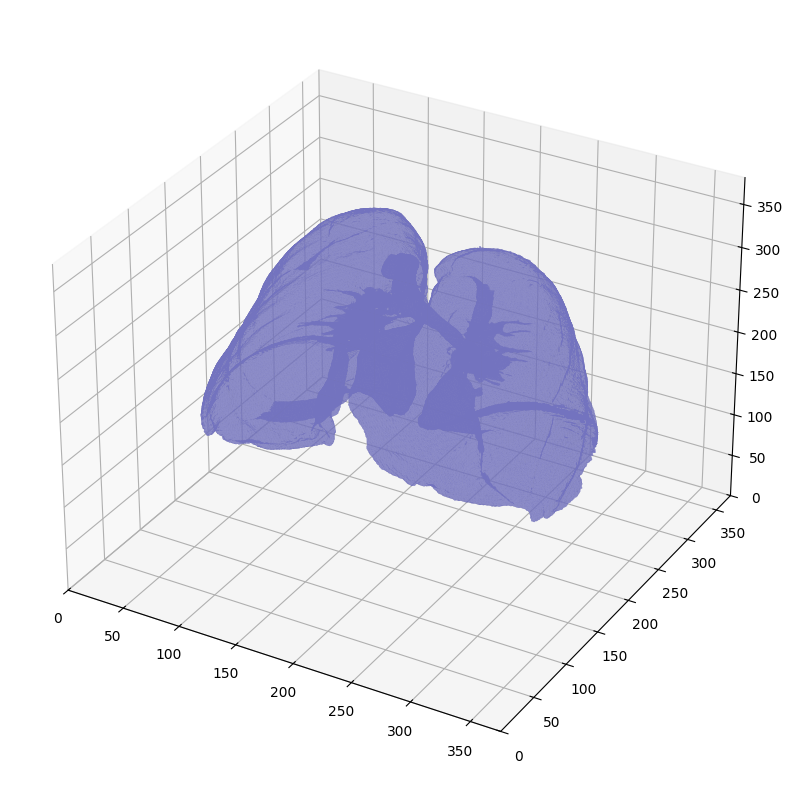

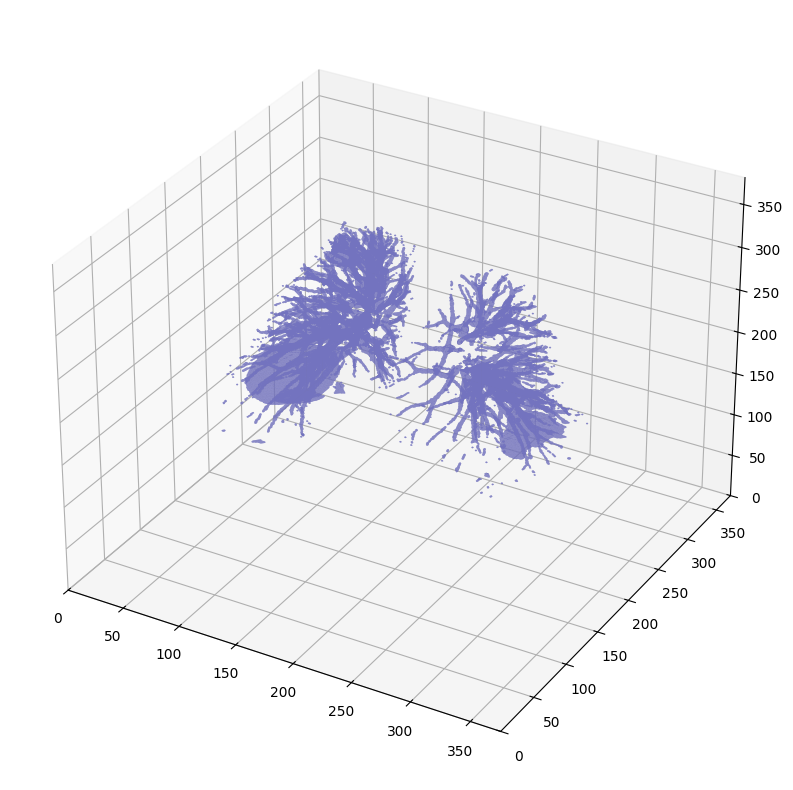

In [35]:
first_patient_path = os.path.join(INPUT_FOLDER, patients[0])
print(f"Loading scans from: {first_patient_path}")

# Load the scans
first_patient = load_scan(first_patient_path)

first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle(not a compact version but just a slice from the middle)
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()


pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)
# Example usage
plot_3d(pix_resampled, 400)
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

plot_3d(segmented_lungs, 0)
plot_3d(segmented_lungs_fill, 0)
plot_3d(segmented_lungs_fill - segmented_lungs, 0)


Helps visualize what a processed slice looks comparing to an unprocessed scan

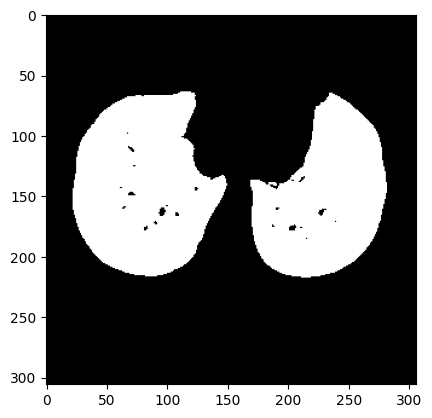

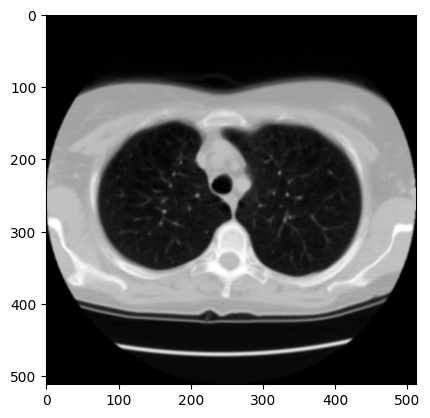

In [15]:
from scipy.ndimage import gaussian_filter

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25  # Not typically recommended for CT scans

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

def get_pixels_hunds(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0

    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)

    # Normalize the image
    image = normalize(image)
    
    # Optionally apply zero centering (be cautious with this for CT scans)
    # image = zero_center(image)

    # Apply Gaussian filter for smoothing
    image = gaussian_filter(image, sigma=1)

    return np.array(image, dtype=np.float32)
segmented_lungs = segment_lung_mask(pix_resampled, False)
plt.imshow(segmented_lungs[80],cmap=plt.cm.gray)
plt.show()
first_patient_path = os.path.join(INPUT_FOLDER, patients[0])
first_patient = load_scan(first_patient_path)
first_patient_pixels = get_pixels_hunds(first_patient)
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()